In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pydotplus as pydot
from IPython.display import Image
from io import StringIO

## Import and view CSV File

Import csv file and display it using Pandas.

In [2]:
titanic_df = pd.read_csv("train.csv")

titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## How does the Data look?
Pandas dataframes give us a lot of useful functionality.

In [3]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some details that are of interest here:
* 38% of passengers in the dataset survived. 
* 177 Age values are missing.

Our hypothesis is that Age is a predictor of survivability, so we have to do something with the missing values.

## Feature Engineering 1 : Impute missing Age values using name 

By tokenizing the names we can get the Honorific (i.e. Mr, Miss, Major) and use these to calculate the missing ages based on the median age for these values.

First we extract the honorifics and add a new column containing these to our dataset.

In [4]:
honorifics = []

for name in titanic_df['Name']:
    honorifics.append(name.split(',')[1].split('.')[0].strip())
    
titanic_df['Honorific'] = honorifics

titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Get an overview of how many honorifics there are.

In [5]:
titanic_df.Honorific.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Honorific, dtype: int64

And how many Null Age values exist for each honorific type.

In [6]:
titanic_df[titanic_df['Age'].isnull()].Honorific.value_counts()

Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Honorific, dtype: int64

Lets reduce the amount of honorifics - this will improve the generalisation of the median Age values for each one.

In [7]:
honorific_map = {
 'Capt': "Serviceman",
 'Col': "Serviceman",
 'Don': "Sir",
 'Dr': "Serviceman",
 'Jonkheer': "Sir",
 'Lady': "Lady",
 'Major': "Serviceman",
 'Master': 'Master',
 'Miss': 'Miss',
 'Mlle': 'Miss',
 'Mme': 'Mrs',
 'Mr': 'Mr',
 'Mrs': 'Mrs',
 'Ms': 'Mrs',
 'Rev': "Serviceman",
 'Sir': "Sir",
 'the Countess': "Lady"
}

titanic_df['Washed Honorific'] = titanic_df.Honorific.map(honorific_map)

Now we'll visualise the Age value distribution for each Honorific by using Matplotlib.

<AxesSubplot:title={'center':'Age'}, xlabel='Washed Honorific'>

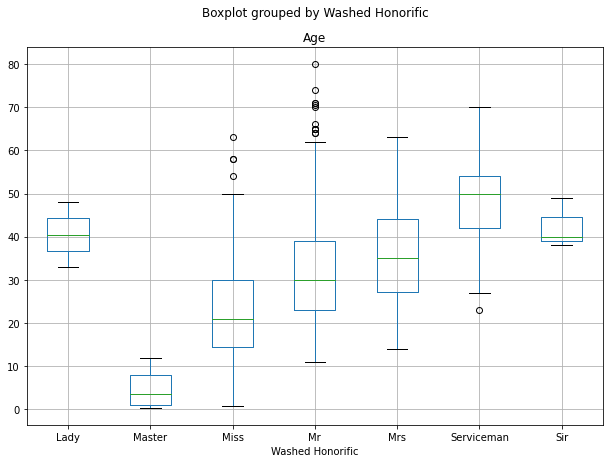

In [8]:
titanic_df.boxplot(column='Age', by='Washed Honorific', grid=True, figsize=(10,7))

And finally we update the missing Age values based on the median age for each Honorific.

In [9]:
titanic_df['Age'].fillna(-1, inplace=True)

honorifics = titanic_df['Washed Honorific'].unique()

medians = dict()
for honorific in honorifics:
    median = titanic_df.Age[(titanic_df["Age"] != -1) & (titanic_df['Washed Honorific'] == honorific)].median()
    medians[honorific] = median
    
for index, row in titanic_df.iterrows():
    if row['Age'] == -1:
        titanic_df.loc[index, 'Age'] = medians[row['Washed Honorific']]

## Feature Engineering 2 : Fix "Sex" Categorical Variable

According to our hypothesis, Sex is also an indicator of survivability. However in our Dataset it is represented as string values, which scikit-learn doesn't like. So we'll need to convert it to a numerical value.

In [10]:
gendermap = {"male": 0, "female": 1}
titanic_df["Sex"] = titanic_df["Sex"].map(gendermap)
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific,Washed Honorific
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr


## Does the Data Reflect Our Hypothesis?

Here we'll use Matplotlib to get visual insight into our Data.

First, how does survivability relate to Class?

<AxesSubplot:xlabel='Pclass', ylabel='count'>

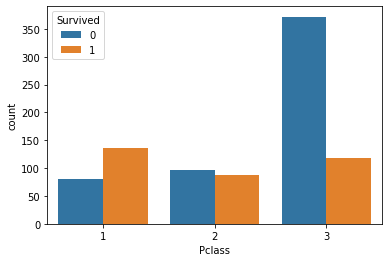

In [11]:
sns.countplot(x='Pclass', hue='Survived', data=titanic_df)

How does survivability relate to Gender?

[Text(0, 0, 'Male'), Text(1, 0, 'Female')]

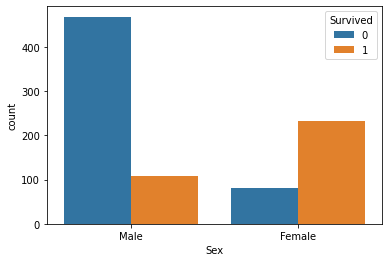

In [15]:
g=sns.countplot(x='Sex', hue='Survived', data=titanic_df)
g.set_xticklabels(['Male','Female'])

And finally, how does survivability relate to Age? For clarity we need to first engineer a new Feature that tells us whether the person is a child or not.

<AxesSubplot:xlabel='Who', ylabel='count'>

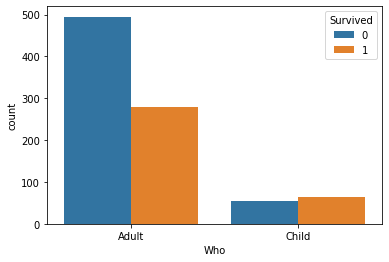

In [20]:
who = []

for age in titanic_df['Age']:
    if age > 17:
        who.append("Adult")
    else:
        who.append("Child")
        
titanic_df['Who'] = who

sns.countplot(x='Who', hue='Survived', data=titanic_df)

## Drop Unecessary Features

We don't *need* to do this, but it makes the Dataset easier to work with (and reduces the chance of unwanted features ending up in the model).

In [21]:
titanic_df = titanic_df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Honorific', 'Washed Honorific', 'Who'], axis=1) 

titanic_df.head(20)

,Survived,Pclass,Sex,Age
0,0,3,0,22.0
1,1,1,1,38.0
2,1,3,1,26.0
3,1,1,1,35.0
4,0,3,0,35.0
5,0,3,0,30.0
6,0,1,0,54.0
7,0,3,0,2.0
8,1,3,1,27.0
9,1,2,1,14.0


## Building Machine Learning Models

First we split our Dataset into Features (PClass, Sex, Age) and Labels (Survived).

In [22]:
features = titanic_df.iloc[:,[1, 2, 3]].values 
labels = titanic_df.iloc[:,0].values 

We then split our Dataset into Training and Testing sets.
* Training set: Used for training our Machine Learning model.
* Testing set: Used for validating the result model.

In [25]:
features_trn, features_tst, labels_trn, labels_tst = train_test_split(features, labels, test_size = .25, random_state=42)

Next we let the Decision Tree learn the relationship between features and labels in the Training set.

In [28]:
dt = tree.DecisionTreeClassifier()
dt.fit(features_trn, labels_trn)

DecisionTreeClassifier()

Note that we didn't tweak any of the models hyperparameters.

We can now test the resulting model using our Testing set, and compare the results with the historical data.

In [31]:
dt_labels_prd = dt.predict(features_tst)
accuracy_score(labels_tst, dt_labels_prd)

0.7488789237668162

A confusion matrix gives us additional insight into the quality of our model.

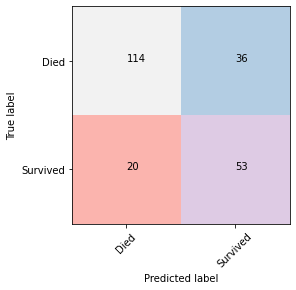

In [32]:
cm = confusion_matrix(dt_labels_prd, labels_tst)

def plot_and_display_confusion_matrix(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
    classNames = ['Died','Survived']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(cm[i][j]))
    plt.show()
    
plot_and_display_confusion_matrix(cm)

Lets visualise the tree to see how it looks.

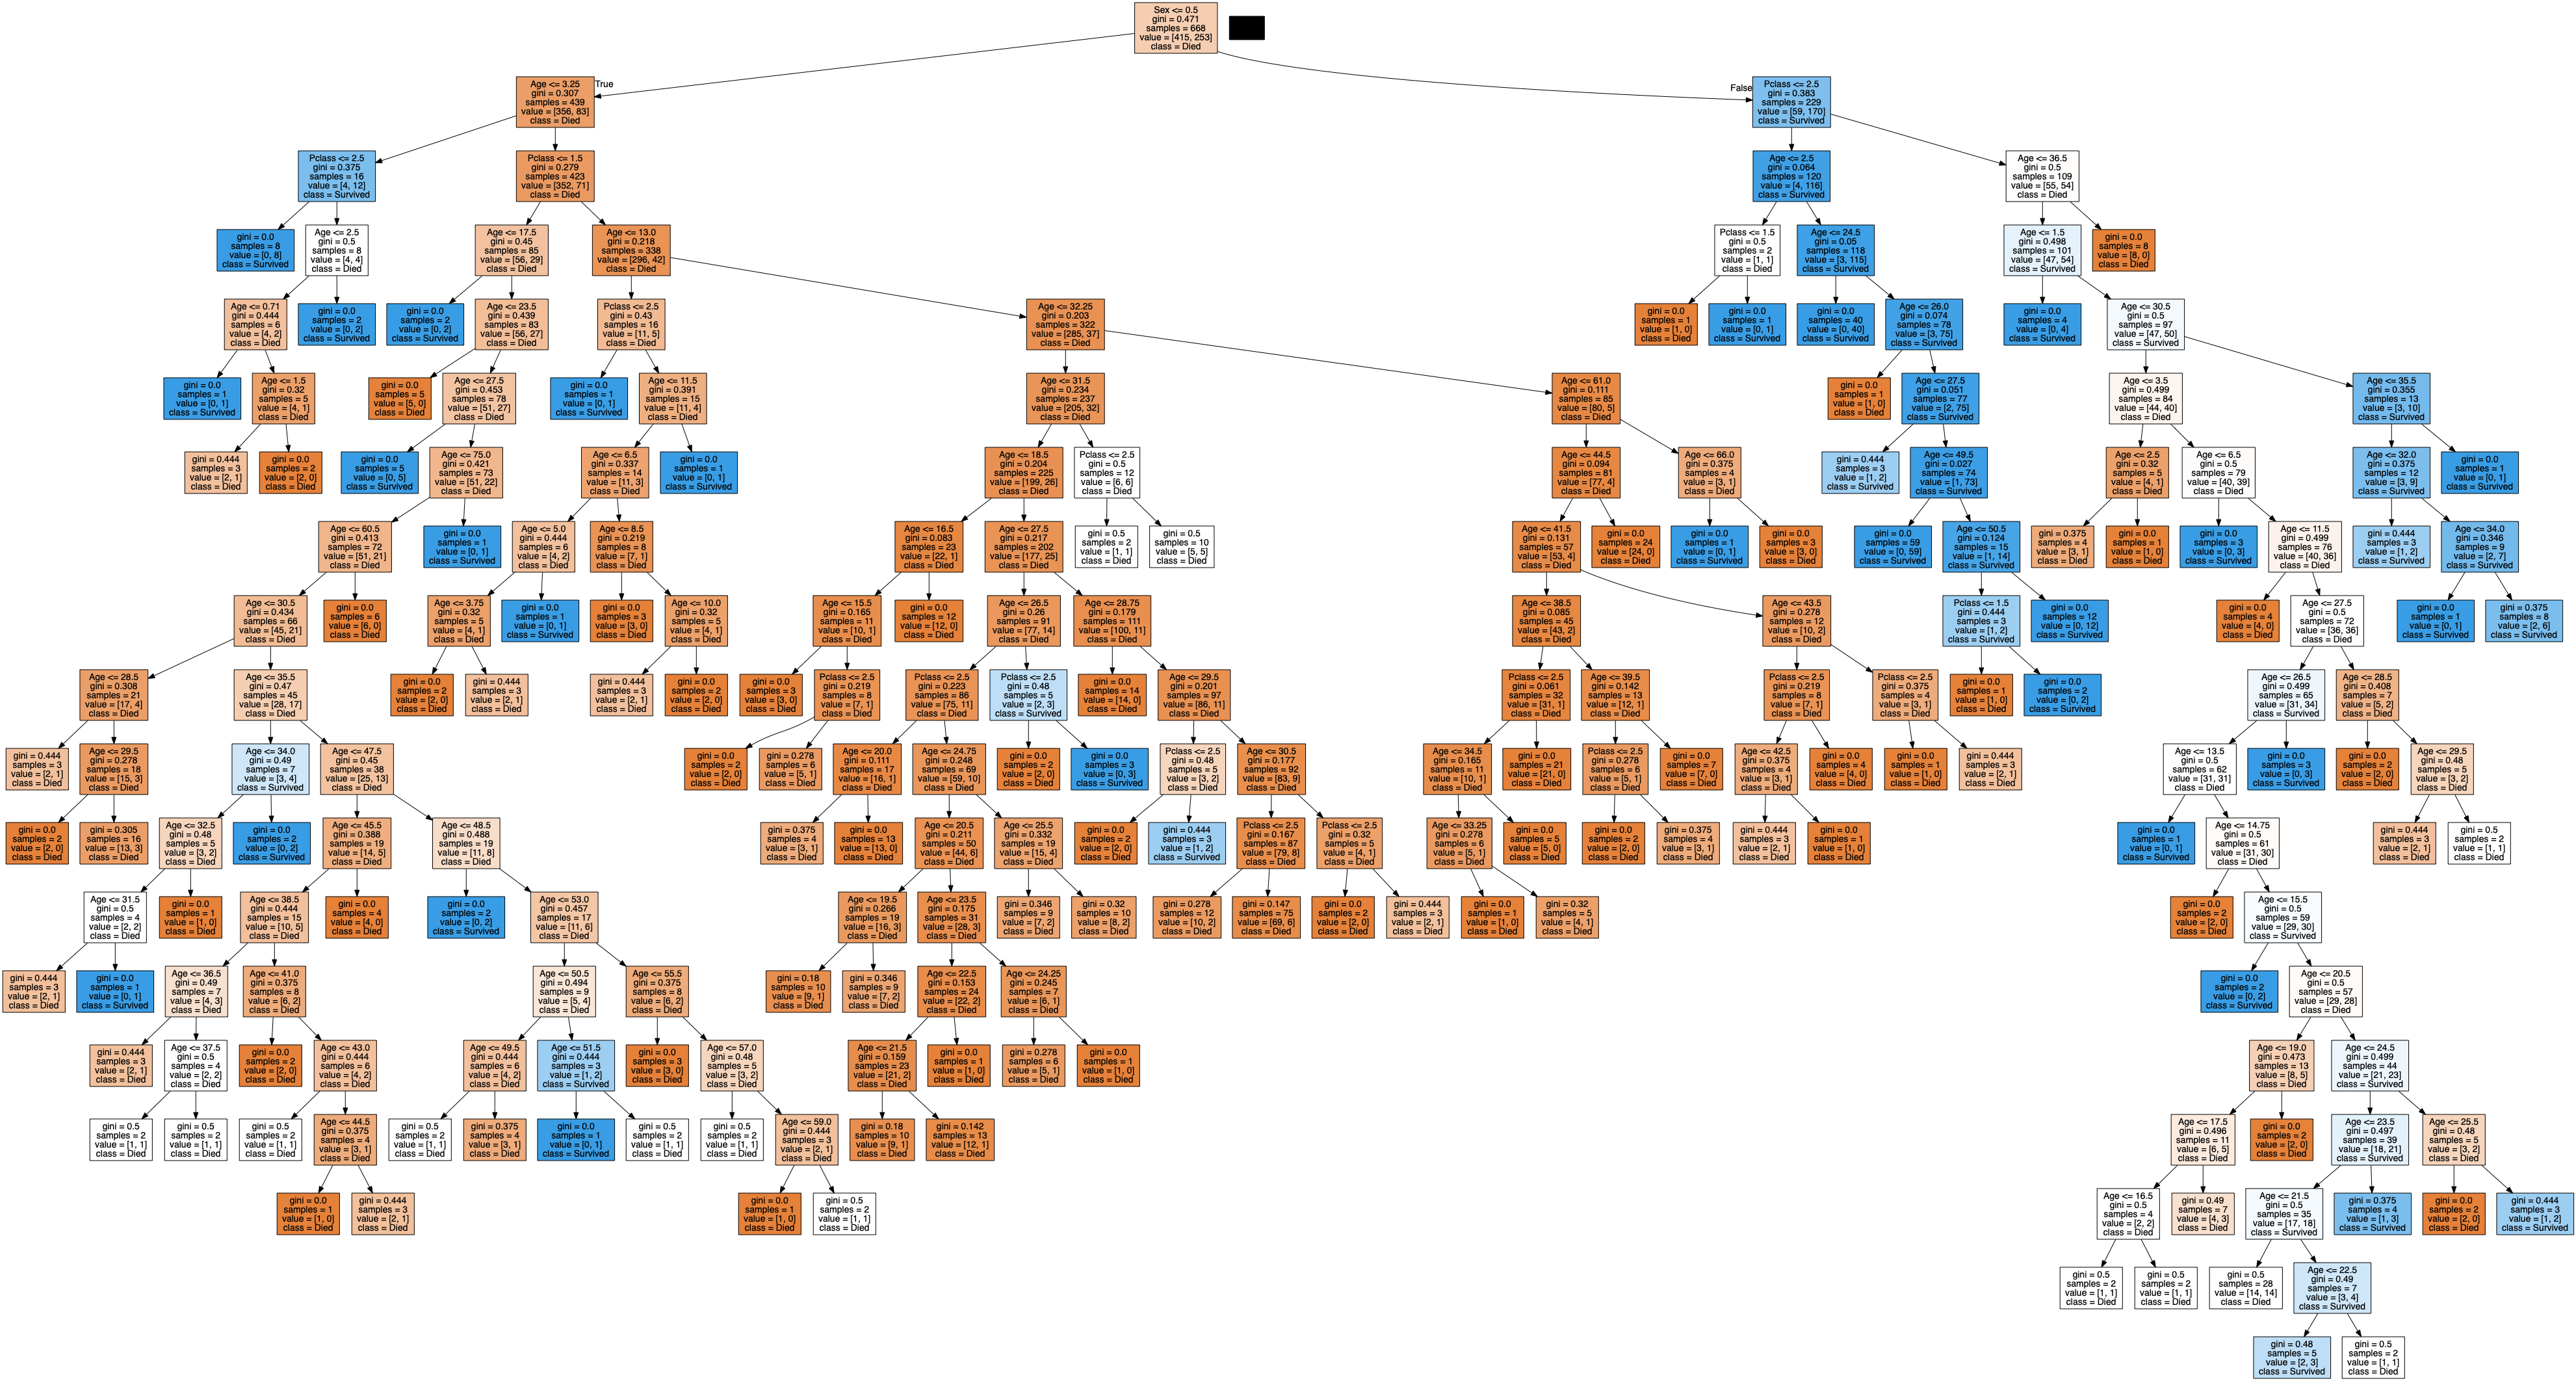

In [33]:
dot_data = StringIO()
tree.export_graphviz(dt, out_file=dot_data, filled=True, 
                    feature_names=list(titanic_df.drop(['Survived'], axis=1).columns), 
                    class_names=['Died', 'Survived'])

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Can we improve the performance of our Decision Tree by tweaking it's hyperparameters? 

Let's try setting the maximum tree depth to the number of features (3).

In [34]:
dt2 = tree.DecisionTreeClassifier(max_depth=3)
dt2.fit(features_trn, labels_trn)

DecisionTreeClassifier(max_depth=3)

And now test and score the model.

In [35]:
dt2_labels_prd = dt2.predict(features_tst)
accuracy_score(labels_tst, dt2_labels_prd)

0.7982062780269058

How does the confusion matrix look for the new version of the Decision Tree?

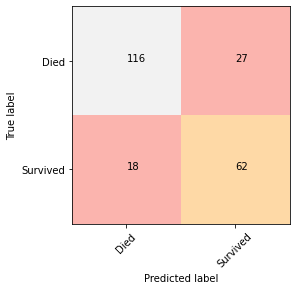

In [36]:
cm2 = confusion_matrix(dt2_labels_prd, labels_tst)
plot_and_display_confusion_matrix(cm2)

We can see from the new confusion matrix that the tweaked algorithm produced a model that did a better job of both predicting Survival and Death.

Lets visualise the new tree, which has been limited to 3 layers.

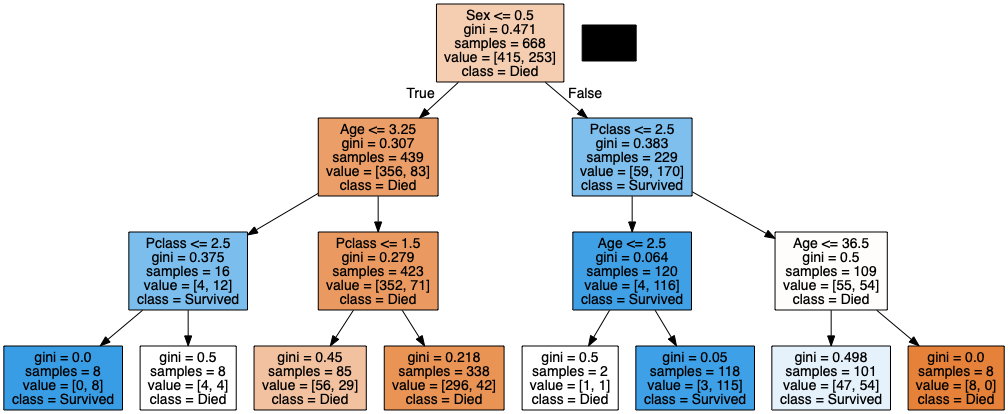

In [37]:
dot_data = StringIO()
tree.export_graphviz(dt2, out_file=dot_data, filled=True, 
                     feature_names=list(titanic_df.drop(['Survived'], axis=1).columns), 
                     class_names=['Died', 'Survived'])

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())